In [1]:
import sys
sys.path.append(".")

In [2]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
import matplotlib.pylab as plt
import pickle
from pathlib import Path
from PlayingCardsGenerator import CardsDataGenerator
from skimage.transform import resize

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [5]:
gen_params = {"samplewise_center":True,\
              "samplewise_std_normalization":True}

In [6]:
generator = CardsDataGenerator(**gen_params, validation_split=0.15)

In [7]:
bs = 64 # batch size

In [8]:
path = Path("dataset/")

In [9]:
img_height = 256
img_width = 256

In [10]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    interpolation="nearest",
    shuffle=True,
    seed=69,
    classes=classes_names) # set as training data

Found 26518 images belonging to 52 classes.


In [11]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    shuffle=True,
    seed=69,
    classes=classes_names) # set as validation data

Found 4648 images belonging to 52 classes.


['clubs' 'diamonds' 'hearts' 'spades']
['2' '3' '4' '5' '6' '7' '8' '9' '10' 'ace' 'jack' 'king' 'queen']


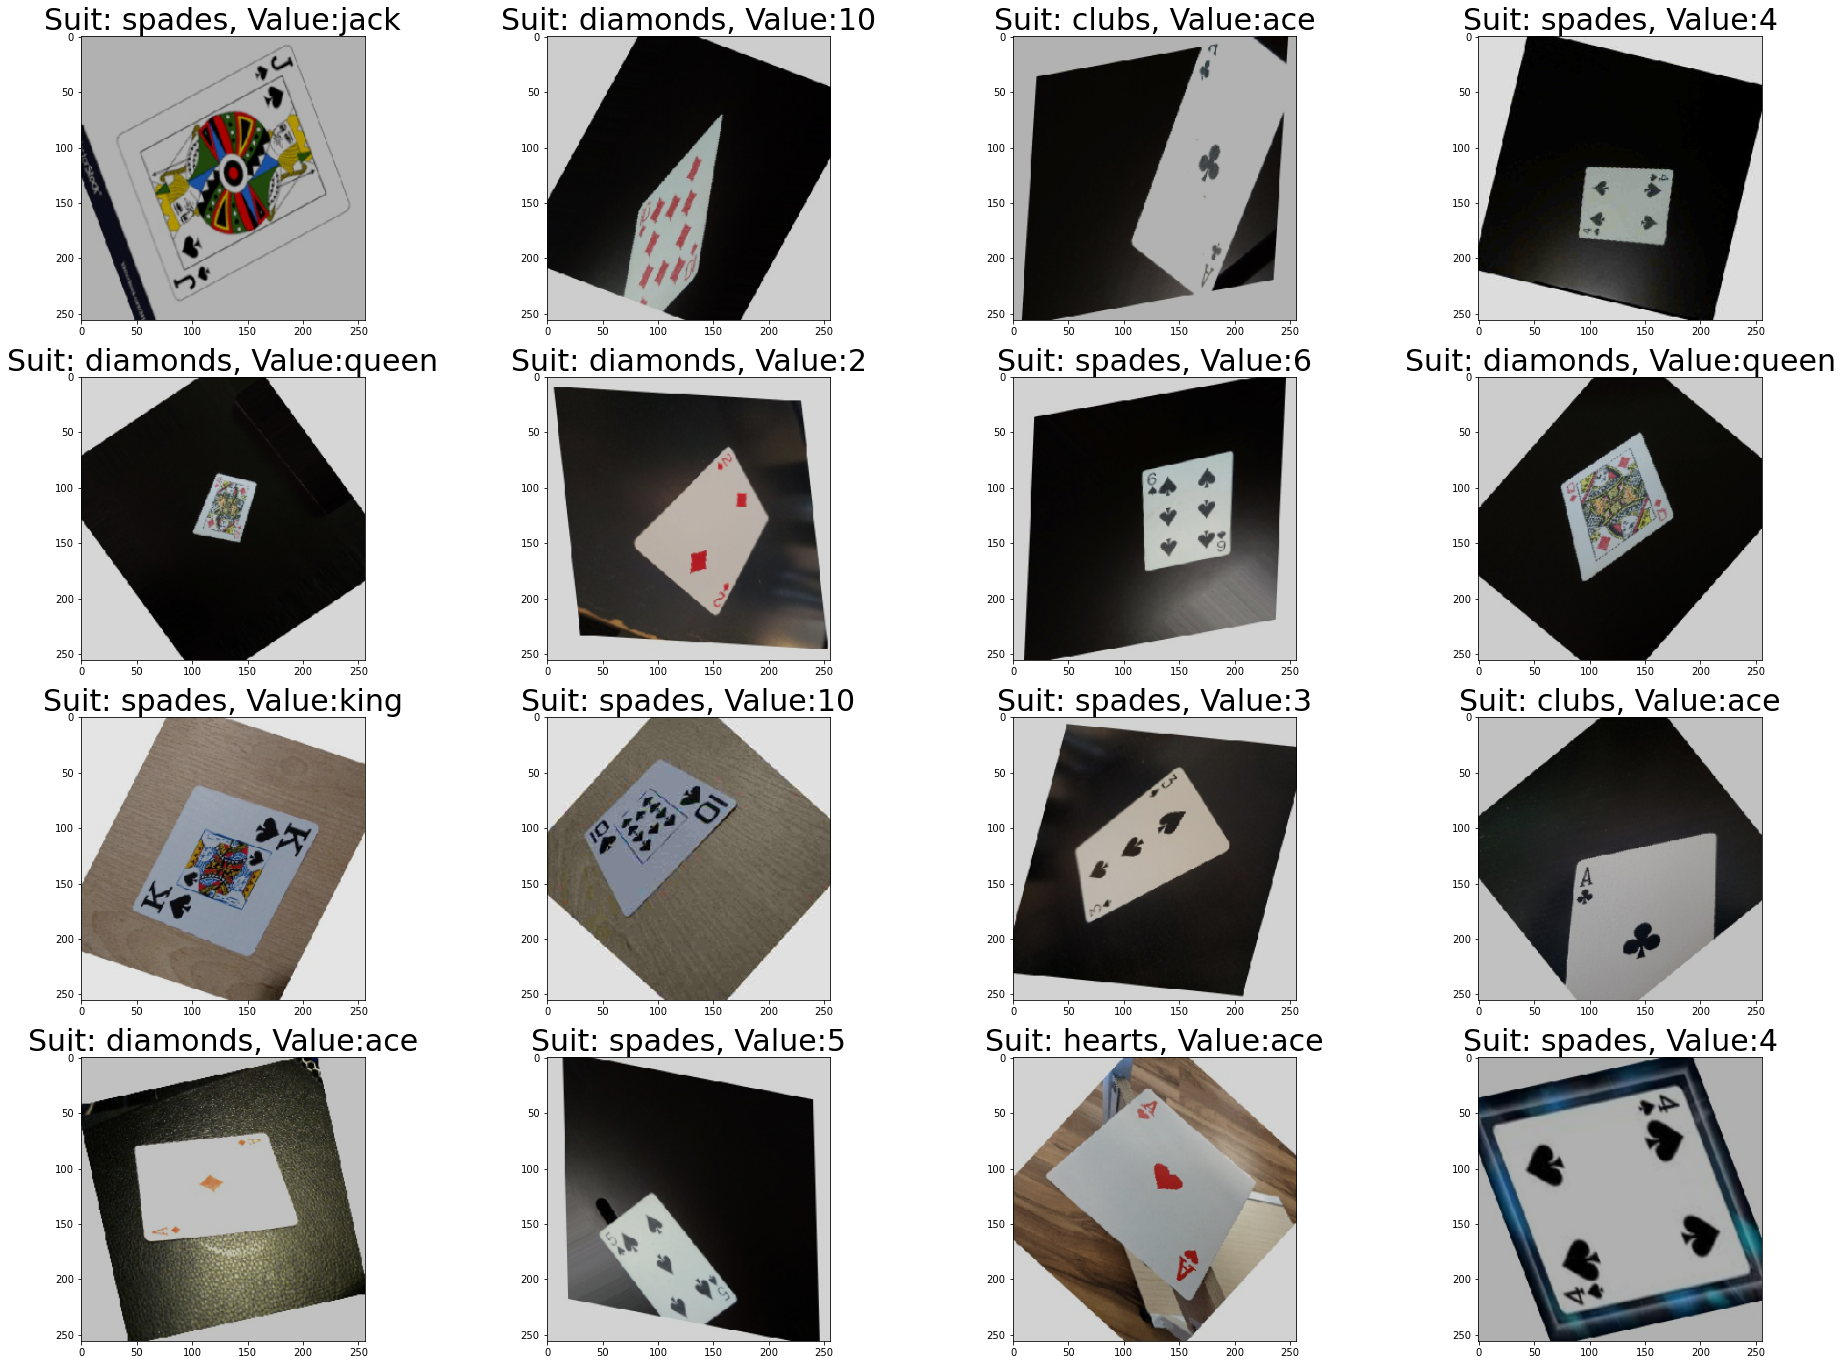

In [12]:
#Exploratory data analysis
Xbatch, Ybatch = train_generator.__getitem__(0)

plt.figure(figsize = (32,24))
suits_names = train_generator.suits_names
values_names = train_generator.values_names

print(suits_names)
print(values_names)

suits = Ybatch[0]
values = Ybatch[1]

for ii in range(int(bs/4)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    suit_idx = int(suits[ii].argmax())
    value_idx = int(values[ii].argmax())
    plt.title("Suit: {}, Value:{}".format(suits_names[suit_idx],values_names[value_idx]),\
              fontsize=30)
plt.show()

In [13]:
ishape = (img_height, img_width, 3)
model_input = tf.keras.layers.Input(shape = ishape)

kernel_size = 3

l1 = tf.keras.layers.Conv2D(8, (kernel_size,kernel_size), activation='relu', padding="same")(model_input)
l2 = tf.keras.layers.Conv2D(8, (kernel_size,kernel_size), activation='relu', padding="same")(l1)
l3 = tf.keras.layers.MaxPooling2D(2, 2)(l2)
l4 = tf.keras.layers.Dropout(0.5)(l3)
l5 = tf.keras.layers.Conv2D(16, (kernel_size,kernel_size), activation='relu', padding="same")(l4)
l6 = tf.keras.layers.Conv2D(16, (kernel_size,kernel_size), activation='relu', padding="same")(l5)
l7 = tf.keras.layers.MaxPooling2D(2,2)(l6)
l8 = tf.keras.layers.Dropout(0.5)(l7)
l9 = tf.keras.layers.Conv2D(32, (kernel_size,kernel_size), activation='relu', padding="same")(l8)
l10 = tf.keras.layers.Conv2D(32, (kernel_size,kernel_size), activation='relu', padding="same")(l9)
l11 = tf.keras.layers.MaxPooling2D(2,2)(l10)
l12 = tf.keras.layers.Dropout(0.5)(l11)
l13 = tf.keras.layers.Conv2D(64, (kernel_size,kernel_size), activation='relu', padding="same")(l12)
l14 = tf.keras.layers.Conv2D(64, (kernel_size,kernel_size), activation='relu', padding="same")(l13)
l15 = tf.keras.layers.MaxPooling2D(2,2)(l14)
l16 = tf.keras.layers.Dropout(0.5)(l15)
l17 = tf.keras.layers.Conv2D(128, (kernel_size,kernel_size), activation='relu', padding="same")(l16)
l18 = tf.keras.layers.Conv2D(128, (kernel_size,kernel_size), activation='relu', padding="same")(l17)
l19 = tf.keras.layers.MaxPooling2D(2,2)(l18)
l20 = tf.keras.layers.Dropout(0.5)(l19)
l21 = tf.keras.layers.Conv2D(256, (kernel_size,kernel_size), activation='relu', padding="same")(l20)
l22 = tf.keras.layers.Conv2D(256, (kernel_size,kernel_size), activation='relu', padding="same")(l21)
l23 = tf.keras.layers.Flatten()(l22)
l_final= tf.keras.layers.Dropout(0.5)(l23)

classifier = tf.keras.layers.Dense(len(suits_names) + len(values_names), activation = 'relu')(l_final)

suits_out = tf.keras.layers.Dense(len(suits_names) , activation = 'softmax')(classifier)
values_out = tf.keras.layers.Dense(len(values_names), activation = 'softmax')(classifier)

model = tf.keras.Model(inputs = model_input, outputs = [suits_out, values_out])

In [14]:
print("Model Summary:")
print(model.summary())

Initial Training Model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv

In [15]:
def scheduler(epoch, lr):
    if epoch%25 == 0 and epoch!= 0:
        lr = lr/(1.5)
    return lr

filepath_name='model_{epoch:d}.h5'

monitor_it = tf.keras.callbacks.ModelCheckpoint(filepath = filepath_name , monitor='val_loss',\
                                             verbose=1,save_best_only=False,\
                                             save_weights_only=False,\
                                             mode='auto',\
                                             save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 40, min_delta=0.01)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [16]:
num_epochs = 1000
init_lr = 0.5e-4
total_size = len(suits_names) + len(values_names)
values_weight = len(values_names)  / total_size
suits_weight =  len(suits_names) / total_size

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = init_lr),\
              loss='categorical_crossentropy',\
              loss_weights={"dense_1":suits_weight,"dense_2":values_weight},\
              metrics=['accuracy'])

In [17]:
history_it = model.fit(train_generator, epochs=num_epochs, verbose = 1, \
                       workers=8, validation_data = (validation_generator),\
                       callbacks= [monitor_it, early_stop, lr_schedule], shuffle=True, initial_epoch=0)

Epoch 1/1000
415/415 [==============================] - ETA: 0s - loss: 2.2866 - dense_1_loss: 1.3887 - dense_2_loss: 2.5628 - dense_1_accuracy: 0.2383 - dense_2_accuracy: 0.0810
Epoch 1: saving model to model_1.h5
415/415 [==============================] - 56s 125ms/step - loss: 2.2866 - dense_1_loss: 1.3887 - dense_2_loss: 2.5628 - dense_1_accuracy: 0.2383 - dense_2_accuracy: 0.0810 - val_loss: 2.2870 - val_dense_1_loss: 1.3862 - val_dense_2_loss: 2.5641 - val_dense_1_accuracy: 0.2760 - val_dense_2_accuracy: 0.1048 - lr: 5.0000e-05
Epoch 2/1000
415/415 [==============================] - ETA: 0s - loss: 2.2548 - dense_1_loss: 1.4078 - dense_2_loss: 2.5154 - dense_1_accuracy: 0.2594 - dense_2_accuracy: 0.1104
Epoch 2: saving model to model_2.h5
415/415 [==============================] - 49s 117ms/step - loss: 2.2548 - dense_1_loss: 1.4078 - dense_2_loss: 2.5154 - dense_1_accuracy: 0.2594 - dense_2_accuracy: 0.1104 - val_loss: 2.2445 - val_dense_1_loss: 1.3891 - val_dense_2_loss: 2.5076

415/415 [==============================] - ETA: 0s - loss: 0.8526 - dense_1_loss: 0.8889 - dense_2_loss: 0.8414 - dense_1_accuracy: 0.6147 - dense_2_accuracy: 0.6948
Epoch 31: saving model to model_31.h5
415/415 [==============================] - 49s 117ms/step - loss: 0.8526 - dense_1_loss: 0.8889 - dense_2_loss: 0.8414 - dense_1_accuracy: 0.6147 - dense_2_accuracy: 0.6948 - val_loss: 1.3171 - val_dense_1_loss: 1.2826 - val_dense_2_loss: 1.3277 - val_dense_1_accuracy: 0.3722 - val_dense_2_accuracy: 0.4824 - lr: 3.3333e-05
Epoch 32/1000
415/415 [==============================] - ETA: 0s - loss: 0.8337 - dense_1_loss: 0.8782 - dense_2_loss: 0.8200 - dense_1_accuracy: 0.6215 - dense_2_accuracy: 0.7009
Epoch 32: saving model to model_32.h5
415/415 [==============================] - 49s 117ms/step - loss: 0.8337 - dense_1_loss: 0.8782 - dense_2_loss: 0.8200 - dense_1_accuracy: 0.6215 - dense_2_accuracy: 0.7009 - val_loss: 1.3115 - val_dense_1_loss: 1.2667 - val_dense_2_loss: 1.3253 - val_d

415/415 [==============================] - ETA: 0s - loss: 0.5502 - dense_1_loss: 0.6498 - dense_2_loss: 0.5195 - dense_1_accuracy: 0.7235 - dense_2_accuracy: 0.8154
Epoch 61: saving model to model_61.h5
415/415 [==============================] - 40s 94ms/step - loss: 0.5502 - dense_1_loss: 0.6498 - dense_2_loss: 0.5195 - dense_1_accuracy: 0.7235 - dense_2_accuracy: 0.8154 - val_loss: 1.1553 - val_dense_1_loss: 1.2207 - val_dense_2_loss: 1.1352 - val_dense_1_accuracy: 0.4262 - val_dense_2_accuracy: 0.5611 - lr: 2.2222e-05
Epoch 62/1000
415/415 [==============================] - ETA: 0s - loss: 0.5422 - dense_1_loss: 0.6501 - dense_2_loss: 0.5090 - dense_1_accuracy: 0.7249 - dense_2_accuracy: 0.8162
Epoch 62: saving model to model_62.h5
415/415 [==============================] - 40s 95ms/step - loss: 0.5422 - dense_1_loss: 0.6501 - dense_2_loss: 0.5090 - dense_1_accuracy: 0.7249 - dense_2_accuracy: 0.8162 - val_loss: 1.1461 - val_dense_1_loss: 1.2359 - val_dense_2_loss: 1.1184 - val_den

415/415 [==============================] - ETA: 0s - loss: 0.4409 - dense_1_loss: 0.5550 - dense_2_loss: 0.4058 - dense_1_accuracy: 0.7675 - dense_2_accuracy: 0.8524
Epoch 91: saving model to model_91.h5
415/415 [==============================] - 40s 95ms/step - loss: 0.4409 - dense_1_loss: 0.5550 - dense_2_loss: 0.4058 - dense_1_accuracy: 0.7675 - dense_2_accuracy: 0.8524 - val_loss: 1.1469 - val_dense_1_loss: 1.2280 - val_dense_2_loss: 1.1220 - val_dense_1_accuracy: 0.4621 - val_dense_2_accuracy: 0.5843 - lr: 1.4815e-05
Epoch 92/1000
415/415 [==============================] - ETA: 0s - loss: 0.4382 - dense_1_loss: 0.5495 - dense_2_loss: 0.4039 - dense_1_accuracy: 0.7667 - dense_2_accuracy: 0.8555
Epoch 92: saving model to model_92.h5
415/415 [==============================] - 40s 95ms/step - loss: 0.4382 - dense_1_loss: 0.5495 - dense_2_loss: 0.4039 - dense_1_accuracy: 0.7667 - dense_2_accuracy: 0.8555 - val_loss: 1.1376 - val_dense_1_loss: 1.2196 - val_dense_2_loss: 1.1124 - val_den

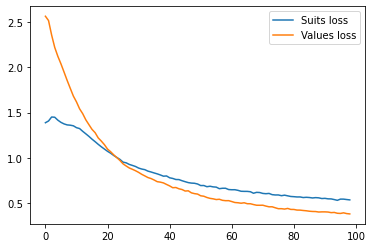

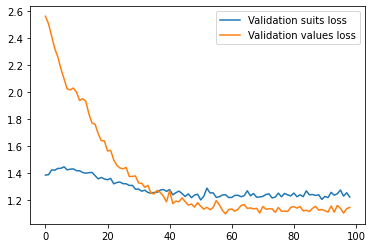

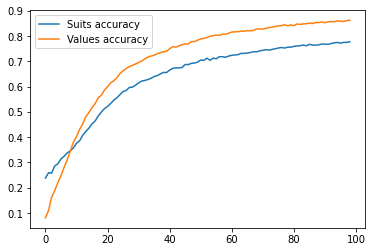

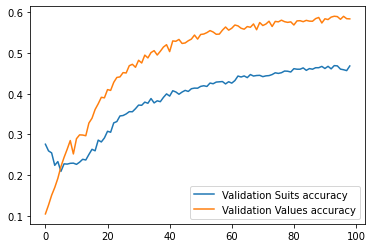

In [18]:
plt.figure()
plt.plot(history_it.history["dense_1_loss"], label = "Suits loss")
plt.plot(history_it.history["dense_2_loss"], label = "Values loss")
plt.legend()
plt.figure()
plt.plot(history_it.history["val_dense_1_loss"], label = "Validation suits loss")
plt.plot(history_it.history["val_dense_2_loss"], label = "Validation values loss")
plt.legend()
plt.figure()
plt.plot(history_it.history["dense_1_accuracy"], label = "Suits accuracy")
plt.plot(history_it.history["dense_2_accuracy"], label = "Values accuracy")
plt.legend()
plt.figure()
plt.plot(history_it.history["val_dense_1_accuracy"], label = "Validation Suits accuracy")
plt.plot(history_it.history["val_dense_2_accuracy"], label = "Validation Values accuracy")
plt.legend()
plt.show()

In [30]:
test_generator = CardsDataGenerator(**gen_params)

path_test = Path("dataset_test/")

bs = 64

test_generator_flow = test_generator.flow_from_directory(
    directory = path_test,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    interpolation="nearest",
    shuffle=True,
    seed=21,
    classes=classes_names)

#sample 50 batches to check accuracy
dense_1_acc = []
dense_2_acc = []
for i in range(50):
    Xbatch, Ybatch = test_generator_flow.__getitem__(i)
    metrics = model.evaluate(Xbatch, Ybatch)
    dense_1_acc.append(metrics[3])
    dense_2_acc.append(metrics[4])
    
dense_1_acc = np.array(dense_1_acc)
dense_2_acc = np.array(dense_2_acc)
    
print("Dense 1 acc mean {}".format(np.mean(dense_1_acc)))
print("Dense 1 acc std {}".format(np.std(dense_1_acc)))
print("Dense 2 acc mean {}".format(np.mean(dense_2_acc)))
print("Dense 2 acc std {}".format(np.std(dense_2_acc)))


Found 7794 images belonging to 52 classes.
2/2 [==============================] - 0s 100ms/step - loss: 1.6586 - dense_1_loss: 1.1211 - dense_2_loss: 1.8239 - dense_1_accuracy: 0.5156 - dense_2_accuracy: 0.5469
Dense 1 acc mean 0.5459375
Dense 1 acc std 0.0551462898230697
Dense 2 acc mean 0.5534375
Dense 2 acc std 0.0626630685192642
